In [1]:
import torch
from torch import nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import trange
from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import time
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import ScalarFormatter

In [2]:
def derivativespsi(X, T, psi):
    psi_real, psi_imag = psi.real, psi.imag  # Extract real & imaginary parts

    dpsi_dx_real, = torch.autograd.grad(psi_real, X, 
                                        grad_outputs=torch.ones_like(psi_real), 
                                        create_graph=True)
    dpsi_dx_imag, = torch.autograd.grad(psi_imag, X, 
                                        grad_outputs=torch.ones_like(psi_imag), 
                                        create_graph=True)
    dpsi_dx = dpsi_dx_real + 1j * dpsi_dx_imag  # Reconstruct complex derivative

    dpsi_dx2_real, = torch.autograd.grad(dpsi_dx.real, X, 
                                         grad_outputs=torch.ones_like(dpsi_dx_real), 
                                         create_graph=True)
    dpsi_dx2_imag, = torch.autograd.grad(dpsi_dx.imag, X, 
                                         grad_outputs=torch.ones_like(dpsi_dx_imag), 
                                         create_graph=True)
    dpsi_dx2 = dpsi_dx2_real + 1j * dpsi_dx2_imag  # Reconstruct complex second derivative

    dpsi_dt_real, = torch.autograd.grad(psi_real, T, 
                                        grad_outputs=torch.ones_like(psi_real), 
                                        create_graph=True)
    dpsi_dt_imag, = torch.autograd.grad(psi_imag, T, 
                                        grad_outputs=torch.ones_like(psi_imag), 
                                        create_graph=True)
    dpsi_dt = dpsi_dt_real + 1j * dpsi_dt_imag  # Reconstruct complex time derivative

    return dpsi_dt, dpsi_dx2

## Breathing mode dynamics

We simulate an alternative quantum dynamic known as the **breathing mode** by changing the frequency of the harmonic oscillator instead of displacing the initial wavefunction. The initial wavefunction remains a zero-centered Gaussian:

$$
\psi_{\text{initial}}(x) = \pi^{-1/4} \exp\left(-\frac{x^2}{2}\right)
$$

The potential is modified to:

$$
V(x) = \frac{1}{2} \omega^2 x^2
$$

with a reduced frequency:

$$
\omega = 0.5
$$

This creates a mismatch between the initial state (ground state of $ \omega = 1 $) and the actual Hamiltonian, inducing a **width oscillation** over time.

**Expected behavior:**

1. The wavepacket remains centered at $ x = 0 $
2. The **width of the Gaussian oscillates** periodically (contracts and expands)
3. This "breathing" arises because the initial wavefunction is not an eigenstate of the modified potential
4. The oscillation period is $ T = 2\pi / \omega = 4\pi $

This setup produces non-classical dynamics while preserving the symmetric shape and zero expectation value of position.


### Analytical Form of the Breathing Mode Wavefunction

The **breathing mode** arises when a quantum harmonic oscillator starts in the ground state of frequency $ \omega_0 = 1 $, but evolves under a different frequency $ \omega < 1 $. This leads to oscillations in the width of the wavefunction.

The initial condition is:

$$
\psi(x, 0) = \pi^{-1/4} \exp\left(-\frac{x^2}{2}\right)
$$

The time-evolved wavefunction under the new Hamiltonian is given by:

$$
\psi(x, t) = \frac{1}{\pi^{1/4} \sqrt{s(t)}} \exp\left(-\frac{x^2}{2 s(t)^2} + i \phi(t) \right)
$$

where:

- $ s(t) $ is the **time-dependent width**:
  $$
  s(t) = \sqrt{\cos^2(\omega t) + \frac{1}{\omega^2} \sin^2(\omega t)}
  $$

- $ \phi(t) $ is a **global phase** that can include both:
  - The geometric/squeezing phase:
    $$
    \phi(t) = -\frac{1}{2} \arctan\left( \omega \tan(\omega t) \right)
    $$
  - And possibly a dynamical phase (e.g., $ -\omega t/2 $)

### Key properties:

1. The center of the wavefunction remains at $ x = 0 $
2. The **width** oscillates with period $ T = 2\pi / \omega $
3. There is **no net motion**, only periodic squeezing and expansion
4. This is not a coherent state — it’s a **squeezed Gaussian**

This behavior models non-classical dynamics often used in quantum optics and cold atoms.



### Analytical Energy of a Squeezed Gaussian State

For an initial Gaussian wavefunction of the form:

$$
\psi(x, 0) = \frac{1}{(\pi \sigma^2)^{1/4}} \exp\left(-\frac{x^2}{2\sigma^2} \right)
$$

evolving under a harmonic oscillator potential with frequency $ \omega $, the total energy is:

$$
E = \frac{1}{4\sigma^2} + \frac{1}{4} \omega^2 \sigma^2
$$

In our case:

- $ \sigma = 1 $
- $ \omega = 0.5 $

So the expected energy is:

$$
E = \frac{1}{4} + \frac{1}{16} = \frac{5}{16} = 0.3125
$$

This corresponds to a non-stationary squeezed state — the energy remains constant in time, but the wavefunction periodically breathes.


## Computational Set-Up

### Set-up for training

In this section, we define the spatial and temporal resolution (`Nx = 100`, `Nt = 100`), the number of training epochs (`100_000`), and the learning rate (`lr = 0.01`). These values correspond to those used in the coherent state results presented in the TFG.

You can modify any of these parameters manually below if you want to explore different resolutions or speed up training for testing purposes.

The code is set up to run on CPU by default. Change `'cpu'` to `'cuda'` if you want to train on a GPU and one is available.

In [5]:
# Hardware (CPU or GPU)
dev = 'cpu' # can be changed to 'cuda' for GPU usage
device = torch.device(dev)

# Network hyperparameters
Nin = 2   # Inputs to the neural network
Nout = 2  # Outputs of the neural network
Nhid1 = 40  # Nodes in the hidden layer
Nhid2 = 40  # Nodes in the hidden layer

# Network parameters
seed = 1
torch.manual_seed(seed)

# Layer 1 parameters (input -> hidden1)
W1 = torch.rand(Nhid1, Nin, requires_grad=True) * (-1.)       # [-1, 0] range, shape (Nhid1, Nin)
B1 = torch.rand(Nhid1, requires_grad=True) * 2. - 1.          # [-1, 1] range, shape (Nhid1,)

# Layer 2 parameters (hidden1 -> hidden2)
W2 = torch.rand(Nhid2, Nhid1, requires_grad=True) * 2. - 1.   # [-1, 1] range, shape (Nhid2, Nhid1)
B2 = torch.rand(Nhid2, requires_grad=True) * 1. - 0.5         # [-0.5, 0.5] range, shape (Nhid2,)

# Layer 3 parameters (hidden2 -> output)
W3 = torch.rand(Nout, Nhid2, requires_grad=True)              # [0, 1] range, shape (Nout, Nhid2)
B3 = torch.rand(Nout, requires_grad=True) * 0.4 - 0.2         # [-0.2, 0.2] range, shape (Nout,)
# Training hyperparameters
epochs = 100000
lr = 0.01  # Learning rate

# Mesh parameters
# For x
Nx = 100                    # Mesh division
train_ax = -7                      # Mesh lower limit
train_bx = 7                       # Mesh upper limit
x_train = torch.linspace(train_ax, train_bx, Nx, requires_grad=True, device=device) 

#For t
Nt = 100                    # Mesh division
train_at = 0                      # Mesh lower limit
train_bt = 2*np.pi                     # Mesh upper limit

t_train = torch.linspace(train_at, train_bt, Nt, requires_grad=True, device=device)

# Create 2D mesh grids
XT_train = torch.meshgrid(x_train, t_train, indexing="ij")  # Shape (Nx, Nt)



X = XT_train[0].reshape(-1, 1).to(device)
T = XT_train[1].reshape(-1, 1).to(device)

X = X.requires_grad_(True).to(device)  # Enable gradient tracking for X
T = T.requires_grad_(True).to(device)  # Enable gradient tracking for T

XT_train = torch.stack([X, T], dim=-1).reshape(-1, 2) # Shape (Nx * Nt, 2)

### Neural network architecture

We define a fully connected neural network with two inputs (space and time) and two outputs: the logarithm of the wavefunction’s magnitude and its phase. This allows us to model the complex-valued solution using only real-valued outputs.

In [6]:
class HarmonicNQS(nn.Module):
    def __init__(self, W1, B1, W2, B2, W3=None, B3=None):
        super(HarmonicNQS, self).__init__()
        self.lc1 = nn.Linear(Nin, Nhid1, bias=True)
        self.actfun1 = nn.Sigmoid()
        self.lc2 = nn.Linear(Nhid1, Nhid2, bias=True)
        self.actfun2 = nn.Tanh()
        self.lc3 = nn.Linear(Nhid2, Nout, bias=True)
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B1)
            self.lc2.weight = nn.Parameter(W2)
            self.lc2.bias = nn.Parameter(B2)
            if W3 is not None and B3 is not None:
                self.lc3.weight = nn.Parameter(W3)
                self.lc3.bias = nn.Parameter(B3)
    def forward(self, x):
        h1 = self.actfun1(self.lc1(x))
        h2 = self.actfun2(self.lc2(h1))
        return self.lc3(h2)

### Learning rate scheduler

To improve convergence, we apply a `StepLR` scheduler which halves the learning rate every `10_000` epochs.

This means the initial learning rate of `0.01` becomes `0.005` at epoch 10_000, `0.0025` at epoch 20_000, and so on. This schedule was shown to accelerate training and stabilise loss descent.

In [7]:
# Initialize and compile network
net = HarmonicNQS(W1, B1, W2, B2)

# Define optimizer
#optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=lr
)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, threshold=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.5)

In [8]:
print("NN architecture:\n", net)

NN architecture:
 HarmonicNQS(
  (lc1): Linear(in_features=2, out_features=40, bias=True)
  (actfun1): Sigmoid()
  (lc2): Linear(in_features=40, out_features=40, bias=True)
  (actfun2): Tanh()
  (lc3): Linear(in_features=40, out_features=2, bias=True)
)


### Loss function

The loss includes contributions from the TDSE residual, initial condition, and boundary conditions but no final condition. These are weighted in the total loss using λ₁ and λ₂. You can find or adjust these weights directly in the training script.

In [9]:
def losswcd():
    ln_abs_psi = net(XT_train)[:,0].reshape(-1,1)  # Shape (Nx*Nt,1)
    phase = net(XT_train)[:,1].reshape(-1,1)       # Shape (Nx*Nt,1)
    psi = torch.exp(ln_abs_psi + 1j * phase)

    
    # Compute derivatives
    dpsi_dt, dpsi_dx2 = derivativespsi(X, T, psi)
    
    # Compute hamiltonian and loss
    omega = 0.5  # freq = 0.5
    V = 0.5 * omega**2 * X**2
    H = -0.5 * dpsi_dx2 + V * psi
    loss=torch.abs(1j * dpsi_dt - H)**2
    loss=loss.mean()  # Sum for all x and t
    
    # Conditions
    
    # Initial condition: moving Gaussian centered at x0=0.5
    x0 = 0.5
    psiini = psi.resize(Nx, Nt)[:, 0]
    x1 = X.resize(Nx, Nt)[:, 0]

    ini=torch.abs(psiini-np.pi**(-1/4)*torch.exp(-x1**2 /2))**2  # Initial condition to be gaussian
    ini = ini.mean()

    
    psiabs=torch.abs(psi.resize(Nx, Nt))**2
    norm=torch.abs(psiabs.sum(dim=0)-1) # Normalization
    norm=norm.mean()
    
    edges=psiabs[-1,:]+psiabs[0,:] # Edges go to zero
    edges=edges.mean()
    
    
    lambda1=10
    lambda2=0
    lambda3=10
    total_loss=loss+lambda1*ini+lambda2*norm+lambda3*edges
    return total_loss, ln_abs_psi, phase, loss, ini, edges

## Training

This section trains the PINN to model the breathing mode. Training progress is printed every 250 epochs. You can adjust `epochs` or `plot_every` to suit your runtime constraints.

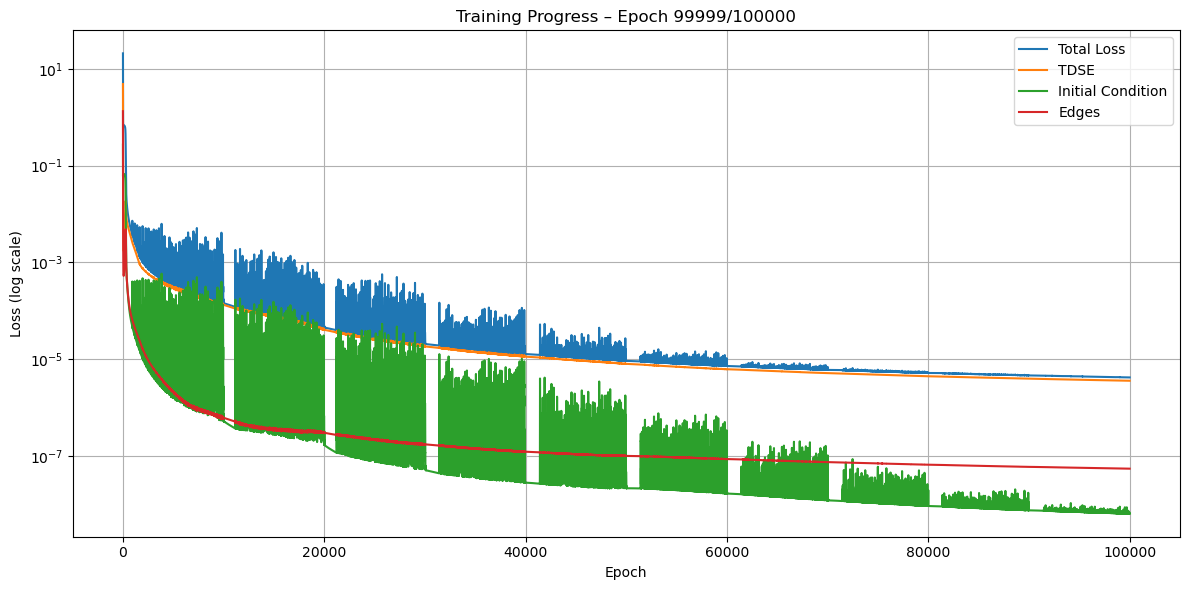


Training completed in 596.48 minutes


In [10]:
start_time = time.time()
plot_every = 250
losswcd_accum, TDSE_accum, ini_accum, edges_accum = [], [], [], []

# Training loop
for i in tqdm(range(epochs), desc="Epochs", leave=True):
    # Update learning rate at epoch 12,500
    #if i == 5000:
        #for param_group in optimizer.param_groups:
            #param_group['lr'] = 0.0001  # New learning rate
    #if i == 25000:
        #for param_group in optimizer.param_groups:
           # param_group['lr'] = 0.00001  # New learning rate
    
    optimizer.zero_grad()
    losswcd0, ln_abs_psi, phase, TDSE, ini, edges = losswcd()
    losswcd0.backward()
    optimizer.step()
    scheduler.step()
    
    # Record losses
    losswcd_accum.append(losswcd0.item())
    TDSE_accum.append(TDSE.item())
    ini_accum.append(ini.item())
    edges_accum.append(edges.item())
    
    # Print learning rate every 251 iterations (as before)
    if i % 251 == 0 or i == epochs - 1:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {i}: Learning Rate: {current_lr}")
    
    # Plotting (unchanged)
    if i % plot_every == 0 or i == epochs -1:
        clear_output(wait=False)
        plt.figure(figsize=(12,6))
        plt.plot(losswcd_accum, label="Total Loss")
        plt.plot(TDSE_accum, label="TDSE")
        plt.plot(ini_accum, label="Initial Condition")
        plt.plot(edges_accum, label="Edges")
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (log scale)")
        plt.title(f"Training Progress – Epoch {i}/{epochs}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# Final timing summary
total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")

## Data

These cells compute all the data that will be needed later to evaluate the model:

In [ ]:
def compute_wavefunction_grids(X, T, net, Nx, Nt, device):
    """
    Computes the wavefunction and its derivatives on a spatiotemporal grid.

    Parameters
    ----------
    X : torch.Tensor
        1D tensor of spatial coordinates (size Nx*Nt).
    T : torch.Tensor
        1D tensor of temporal coordinates (size Nx*Nt).
    net : torch.nn.Module
        Neural network model that outputs ln|ψ| and phase of ψ.
    Nx : int
        Number of spatial points.
    Nt : int
        Number of temporal points.
    device : torch.device
        Device to move tensors to (e.g. torch.device('cuda') or 'cpu').

    Returns
    -------
    dict
        Dictionary containing:
        - X_grid, T_grid: grid-shaped coordinate tensors
        - psi_grid: complex-valued ψ(x,t) on grid
        - dpsi_dx_grid: ∂ψ/∂x on grid
        - dpsi_dt_grid: ∂ψ/∂t on grid
        - dpsi_dx2_grid: ∂²ψ/∂x² on grid
    """
    X = X.requires_grad_(True).to(device).reshape(-1, 1)
    T = T.requires_grad_(True).to(device).reshape(-1, 1)
    XT = torch.cat([X, T], dim=1)

    ln_abs_psi = net(XT)[:, 0].reshape(-1, 1)
    phase = net(XT)[:, 1].reshape(-1, 1)
    psi = torch.exp(ln_abs_psi) * torch.exp(1j * phase)

    psi_real, psi_imag = psi.real, psi.imag

    # First and second derivatives
    dpsi_dt, dpsi_dx2 = derivativespsi(X, T, psi)

    dpsi_dx_real, = torch.autograd.grad(
        psi_real, X,
        grad_outputs=torch.ones_like(psi_real),
        create_graph=True
    )

    dpsi_dx_imag, = torch.autograd.grad(
        psi_imag, X,
        grad_outputs=torch.ones_like(psi_imag),
        create_graph=True
    )

    if dpsi_dx_real is None:
        dpsi_dx_real = torch.zeros_like(X)
    if dpsi_dx_imag is None:
        dpsi_dx_imag = torch.zeros_like(X)

    dpsi_dx = dpsi_dx_real + 1j * dpsi_dx_imag

    # Reshape to grid form (Nx, Nt)
    X_grid = X.view(Nx, Nt)
    T_grid = T.view(Nx, Nt)
    psi_grid = psi.view(Nx, Nt)
    dpsi_dx_grid = dpsi_dx.view(Nx, Nt)
    dpsi_dt_grid = dpsi_dt.view(Nx, Nt)
    dpsi_dx2_grid = dpsi_dx2.view(Nx, Nt)

    return {
        "X_grid": X_grid,
        "T_grid": T_grid,
        "psi_grid": psi_grid,
        "dpsi_dx_grid": dpsi_dx_grid,
        "dpsi_dt_grid": dpsi_dt_grid,
        "dpsi_dx2_grid": dpsi_dx2_grid
    }

In [ ]:
grids = compute_wavefunction_grids(X, T, net, Nx, Nt, device)

X_grid = grids["X_grid"]
T_grid = grids["T_grid"]
psi_grid = grids["psi_grid"]
dpsi_dx_grid = grids["dpsi_dx_grid"]
dpsi_dt_grid = grids["dpsi_dt_grid"]
dpsi_dx2_grid = grids["dpsi_dx2_grid"]


In [18]:
def breathing_mode_grid_from_mesh(X, T, omega=0.5):
    """
    Computes the breathing mode wavefunction ψ(X, T) on a full spacetime grid,
    for an initial Gaussian evolved under a harmonic oscillator with frequency omega.

    Parameters:
        X (torch.Tensor): 2D tensor of shape (Nx, Nt), meshgrid of x values
        T (torch.Tensor): 2D tensor of shape (Nx, Nt), meshgrid of t values
        omega (float): Frequency of the harmonic potential (after the quench)

    Returns:
        psi (torch.Tensor): Complex tensor of shape (Nx, Nt)
    """
    # Time-dependent width factor (scaling from exact solution of TDSE after quench)
    s_t = torch.sqrt(torch.cos(omega * T)**2 + (1 / omega**2) * torch.sin(omega * T)**2)

    # Phase factor from width evolution (optional but matches exact solution)
    phase = -0.5 * torch.atan(omega * torch.tan(omega * T))  # dynamical phase
    dyn_phase = torch.exp(-1j * (0.5 * omega * T + phase))

    # Pre-factor: 1 / (π^1/4 * sqrt(s(t)))
    prefactor = (1 / np.pi**0.25) / torch.sqrt(s_t)

    # Gaussian with time-dependent width
    argument = - X**2 / (2 * s_t**2)
    psi = prefactor * torch.exp(argument + 1j * phase) * dyn_phase

    return psi


In [19]:
psi_analy=breathing_mode_grid_from_mesh(X_grid, T_grid, w)

In [32]:
def compute_overlap(psi_nn, psi_analytic, X, T):
    """
    Computes the normalized overlap and fidelity between two wavefunctions
    on a spacetime grid defined by X and T.

    Parameters:
        psi_nn (torch.Tensor): Neural network wavefunction, shape (nx, nt), complex
        psi_analytic (torch.Tensor): Analytical wavefunction, shape (nx, nt), complex
        X (torch.Tensor): Spatial grid meshgrid, shape (nx, nt)
        T (torch.Tensor): Temporal grid meshgrid, shape (nx, nt)

    Returns:
        overlap (torch.Tensor): Complex normalized overlap
        fidelity (torch.Tensor): Real-valued fidelity (|overlap|^2)
    """
    # Compute step sizes assuming uniform grid
    dx = (X[1,0] - X[0,0]).item()
    dt = (T[0,1] - T[0,0]).item()

    integrand = torch.conj(psi_analytic) * psi_nn  # (nx, nt)
    inner_x = torch.trapz(integrand, dx=dx, dim=0)  # integrate over x → (nt,)
    inner_total = torch.trapz(inner_x, dx=dt, dim=0)  # integrate over t → scalar

    norm_nn = torch.trapz(torch.trapz(torch.abs(psi_nn)**2, dx=dx, dim=0), dx=dt, dim=0)
    norm_analytic = torch.trapz(torch.trapz(torch.abs(psi_analytic)**2, dx=dx, dim=0), dx=dt, dim=0)

    overlap = inner_total / torch.sqrt(norm_nn * norm_analytic)
    fidelity = torch.abs(overlap)**2

    return fidelity

In [33]:
overlap=compute_overlap(psi_grid, psi_analy, X_grid, T_grid)
overlap

tensor(0.9684, grad_fn=<PowBackward0>)

## Visualisation of results

The following plots are used to evaluate the PINN’s performance in modelling the breathing mode. Comparisons are made with the analytical solution where appropriate. All figures are saved in the following folder:

In [14]:
epochs = len(losswcd_accum)
w=0.5
# === Create folder name ===
folder_name = f"w_{w}_{epochs}_{lr}_{Nhid1}_{Nhid2}_{Nt}_2"
os.makedirs(folder_name, exist_ok=True)  # Create if not exists

### Training loss

This plot shows how the total loss and individual components (TDSE residual, initial condition, etc.) evolve over training. Use this to confirm convergence.

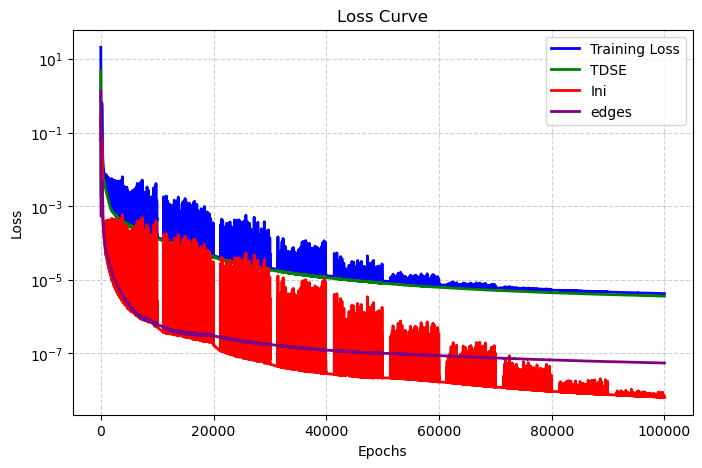

In [15]:
epochs = np.arange(len(losswcd_accum))

plt.figure(figsize=(8, 5))
plt.plot(epochs, losswcd_accum, label='Training Loss', color='b', linewidth=2)
plt.plot(epochs, TDSE_accum, label='TDSE', color='green', linewidth=2)
plt.plot(epochs, ini_accum, label='Ini', color='red', linewidth=2)
plt.plot(epochs, edges_accum, label='edges', color='purple', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.yscale('log')  # Optional: Log scale for better visualization
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(f"{folder_name}/{folder_name}_loss_curve.png", dpi=300)
plt.show()
plt.close()

### Wavefunction plots
Here are some plots to see how well our PINN predictions match out analytical ones

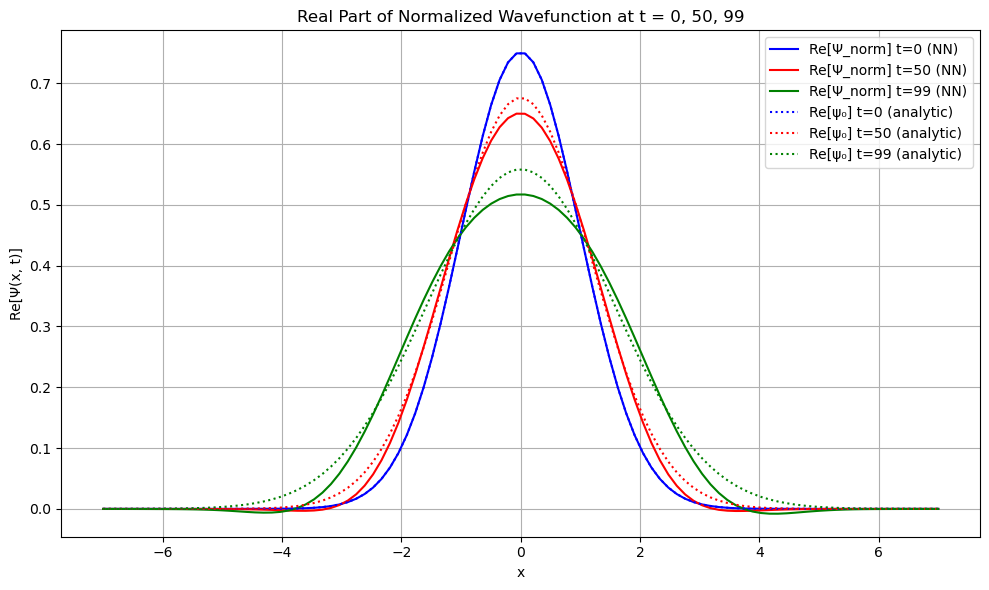

In [20]:
plt.figure(figsize=(10, 6))

# Calculate psi and normalize it
dx = (train_bx - train_ax) / (Nx - 1)
norms = torch.sum(torch.abs(psi_grid)**2, dim=0, keepdim=True) * dx
psi_normalized = psi_grid / torch.sqrt(norms)

# x values for plotting
x_vals = X_grid[:, 0].detach().numpy()
psi_real = psi_normalized.real.detach()


# Compute analytic wavefunction at three times
psi0_t0 = psi_analy[:,0]
psi0_t50 = psi_analy[:,12]
psi0_t99 = psi_analy[:,24]

# --- Plotting ---
plt.plot(x_vals, psi_real[:, 0].numpy(), label="Re[Ψ_norm] t=0 (NN)", color="blue")
plt.plot(x_vals, psi_real[:, 12].numpy(), label="Re[Ψ_norm] t=50 (NN)", color="red")
plt.plot(x_vals, psi_real[:, 24].numpy(), label="Re[Ψ_norm] t=99 (NN)", color="green")

plt.plot(x_vals, psi0_t0.real.detach().numpy(), ':', color='blue', label="Re[ψ₀] t=0 (analytic)")
plt.plot(x_vals, psi0_t50.real.detach().numpy(), ':', color='red', label="Re[ψ₀] t=50 (analytic)")
plt.plot(x_vals, psi0_t99.real.detach().numpy(), ':', color='green', label="Re[ψ₀] t=99 (analytic)")

#plt.plot(x_vals, psi0_eff_t0.real.detach().numpy(), '--', color='cyan', label="Re[ψ₀] t=0 (analytic, ω')")
#plt.plot(x_vals, psi0_eff_t50.real.detach().numpy(), '--', color='magenta', label="Re[ψ₀] t=50 (analytic, ω')")
#plt.plot(x_vals, psi0_eff_t99.real.detach().numpy(), '--', color='orange', label="Re[ψ₀] t=99 (analytic, ω')")

plt.title("Real Part of Normalized Wavefunction at t = 0, 50, 99")
plt.xlabel("x")
plt.ylabel("Re[Ψ(x, t)]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{folder_name}/{folder_name}_real_psi_normalized.png", dpi=300)
plt.show()
plt.close()


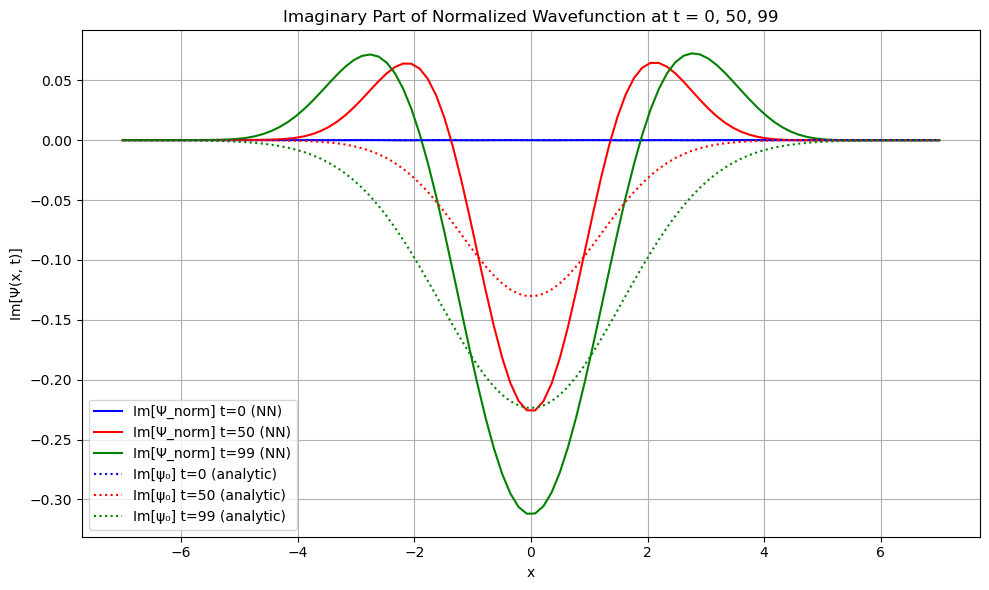

In [21]:
plt.figure(figsize=(10, 6))

# Imaginary part of the normalized wavefunction
psi_imag = psi_normalized.imag.detach()

# Plot imaginary parts from NN (normalized)
plt.plot(x_vals, psi_imag[:, 0].numpy(), label="Im[Ψ_norm] t=0 (NN)", color="blue")
plt.plot(x_vals, psi_imag[:, 12].numpy(), label="Im[Ψ_norm] t=50 (NN)", color="red")
plt.plot(x_vals, psi_imag[:, 24].numpy(), label="Im[Ψ_norm] t=99 (NN)", color="green")

# Plot imaginary parts from analytic solution
plt.plot(x_vals, psi0_t0.imag.detach().numpy(), ':', color='blue', label="Im[ψ₀] t=0 (analytic)")
plt.plot(x_vals, psi0_t50.imag.detach().numpy(), ':', color='red', label="Im[ψ₀] t=50 (analytic)")
plt.plot(x_vals, psi0_t99.imag.detach().numpy(), ':', color='green', label="Im[ψ₀] t=99 (analytic)")

#plt.plot(x_vals, psi0_eff_t0.imag.detach().numpy(), '--', color='cyan', label="Im[ψ₀] t=0 (analytic, ω')")
#plt.plot(x_vals, psi0_eff_t50.imag.detach().numpy(), '--', color='magenta', label="Im[ψ₀] t=50 (analytic, ω')")
#plt.plot(x_vals, psi0_eff_t99.imag.detach().numpy(), '--', color='orange', label="Im[ψ₀] t=99 (analytic, ω')")

# Plot decorations
plt.title("Imaginary Part of Normalized Wavefunction at t = 0, 50, 99")
plt.xlabel("x")
plt.ylabel("Im[Ψ(x, t)]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{folder_name}/{folder_name}_imag_psi_normalized.png", dpi=300)
plt.show()
plt.close()

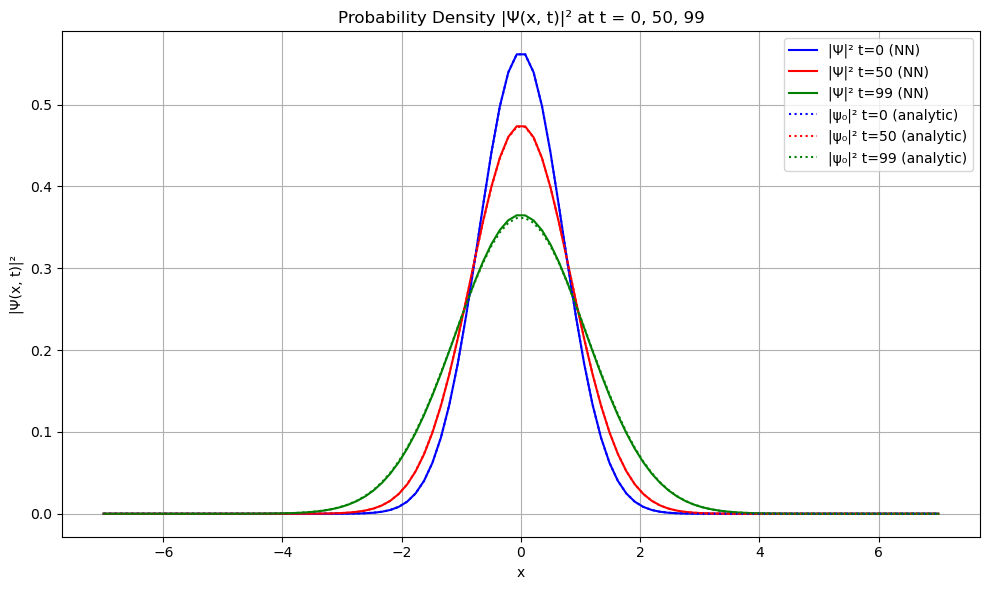

In [22]:
plt.figure(figsize=(10, 6))
psi_sq = torch.abs(psi_normalized)**2
plt.plot(x_vals, psi_sq[:, 0].detach().numpy(), label="|Ψ|² t=0 (NN)", color="blue")
plt.plot(x_vals, psi_sq[:, 12].detach().numpy(), label="|Ψ|² t=50 (NN)", color="red")
plt.plot(x_vals, psi_sq[:, 24].detach().numpy(), label="|Ψ|² t=99 (NN)", color="green")
#plt.plot(x_vals, psi_sq[:, 51].detach().numpy(), label="|Ψ|² t=51 (NN)", color="yellow")

plt.plot(x_vals, (torch.abs(psi0_t0)**2).detach().numpy(), ':', color="blue", label="|ψ₀|² t=0 (analytic)")
plt.plot(x_vals, (torch.abs(psi0_t50)**2).detach().numpy(), ':', color="red", label="|ψ₀|² t=50 (analytic)")
plt.plot(x_vals, (torch.abs(psi0_t99)**2).detach().numpy(), ':', color="green", label="|ψ₀|² t=99 (analytic)")

# Analítica ω' (només modulus squared ja calculat!)
#plt.plot(x_vals, psi0_eff_sq_t0.detach().numpy(), '--', color='cyan', label="|ψ₀|² t=0 (analytic, ω')")
#plt.plot(x_vals, psi0_eff_sq_t50.detach().numpy(), '--', color='magenta', label="|ψ₀|² t=50 (analytic, ω')")
#plt.plot(x_vals, psi0_eff_sq_t99.detach().numpy(), '--', color='orange', label="|ψ₀|² t=99 (analytic, ω')")

plt.title("Probability Density |Ψ(x, t)|² at t = 0, 50, 99")
plt.xlabel("x")
plt.ylabel("|Ψ(x, t)|²")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{folder_name}/{folder_name}_modulus_squared.png", dpi=300)
plt.show()
plt.close()

### Energy conservation

We plot the predicted kinetic and potential energies over time and compare them with the analytical values. The total energy should remain approximately constant.

In [50]:
def plot_energy_components(X, T, psi, dpsi_dx2, omega, folder_name=None, title="Energy_Components_Over_Time"):
    dx = (X[1, 0] - X[0, 0]).item()

    # Energy densities
    kinetic_density = 0.5 * torch.real(torch.conj(psi) * (-dpsi_dx2))
    potential_density = omega**2 * 0.5 * (X ** 2) * torch.abs(psi) ** 2
    total_density = kinetic_density + potential_density

    # Integrate over space
    kinetic_energy = torch.trapz(kinetic_density, dx=dx, dim=0)
    potential_energy = torch.trapz(potential_density, dx=dx, dim=0)
    total_energy = torch.trapz(total_density, dx=dx, dim=0)

    # Normalize
    norm = torch.trapz(torch.abs(psi) ** 2, dx=dx, dim=0)
    kinetic_energy /= norm
    potential_energy /= norm
    total_energy /= norm

    # Convert to NumPy
    times_np = T[0, :].detach().cpu().numpy()
    times_rescaled = times_np / (2 * np.pi)
    kinetic_np = kinetic_energy.detach().cpu().numpy()
    potential_np = potential_energy.detach().cpu().numpy()
    total_np = np.abs(total_energy.detach().cpu().numpy())

    # Analytical s(t) and derivatives
    s_t = np.sqrt(np.cos(omega * times_np)**2 + (1 / omega**2) * np.sin(omega * times_np)**2)
    ds_dt = (1 - 1 / omega**2) * np.sin(2 * omega * times_np) * omega / (2 * s_t)

    # Analytical energy components
    kinetic_analytical = 0.25 * (1 / s_t**2 + ds_dt**2)
    potential_analytical = 0.25 * omega**2 * s_t**2
    total_analytical = kinetic_analytical + potential_analytical

    # Relative error stats
    analytical_E = 0.25 + 0.25 * omega**2  # For sigma = 1
    rel_errors = np.abs((total_np - analytical_E) / analytical_E)
    mean_rel_error = np.mean(rel_errors)
    max_rel_error = np.max(rel_errors)

    print(f"Mean relative error: {mean_rel_error:.3e}")
    print(f"Max relative error:  {max_rel_error:.3e}")

    # Plotting
    cmap = plt.get_cmap('RdBu')
    color_anal_kin = cmap(0.3)
    color_kinetic = cmap(0.1)
    color_potential = cmap(0.9)
    color_total = cmap(0.6)

    figsize = (4, 4)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(times_rescaled, total_np, label='Total', color="purple", lw=1)
    ax.plot(times_rescaled, kinetic_np, label='Kinetic', color=color_kinetic)
    ax.plot(times_rescaled, potential_np, label='Potential', color=color_potential)

    # Analytical dashed overlays
    ax.plot(times_rescaled, total_analytical, '--', color="mediumpurple", label='Analytical Total', lw=1)
    ax.plot(times_rescaled, kinetic_analytical, '--', color=color_anal_kin, label='Analytical Kinetic', lw=1)
    ax.plot(times_rescaled, potential_analytical, '--', color="gray", label='Analytical Potential', lw=1)

    ax.set_xlabel("$t$ $/$ $2\pi$ (cycles)")
    ax.set_ylabel("Energy (h.o. units)")
    ax.legend(fontsize=7, loc="lower left")
    ax.set_aspect(1. / ax.get_data_ratio())
    plt.tight_layout()

    if folder_name:
        os.makedirs(folder_name, exist_ok=True)
        plt.savefig(f"{folder_name}/{folder_name}_{title}.pdf")

    plt.show()

    return mean_rel_error, max_rel_error


Mean relative error: 1.212e-02
Max relative error:  2.072e-02


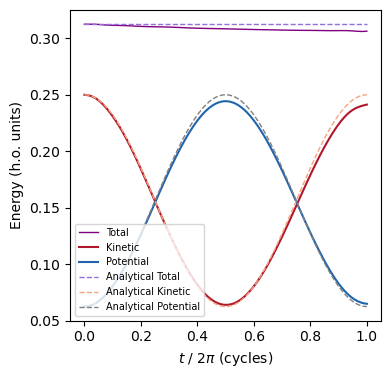

In [51]:
mean_rel_error, max_rel_error=plot_energy_components(X_grid, T_grid, psi_grid, dpsi_dx2_grid, w, folder_name=folder_name)

### Wavefunction components

The following figures show the predicted wavefunction over the spacetime grid:
- Real part
- Imaginary part
- Absolute value
- Relative error compared to the analytical solution

In [27]:
def plot_matrix(X, T, M, title="Matrix Visualization", folder_name=None, name='test'):
    """
    Plots a 2D matrix using a diverging colourmap and saves the plot if a folder is specified.

    Parameters:
        X, T (torch.Tensor): Meshgrid tensors of shape (Nx, Nt)
        M (array-like or torch.Tensor): 2D matrix of shape (Nx, Nt)
        title (str): Title of the colourmap and filename (default "Matrix Visualization")
        folder_name (str, optional): Folder path for saving the plot as a PDF
    """
    t_train = T[0, :]
    times = t_train.detach().cpu().numpy()
    times_rescaled = times / (2 * np.pi)
    x_train = X[:,0]
    x = x_train.detach().cpu().numpy()
    cmap = mpl.colormaps.get_cmap('RdBu')
    cmap.set_bad(color='green')
    vabs = np.abs(M).max()
    norm = TwoSlopeNorm(vmin=-vabs, vcenter=0, vmax=vabs)

    if hasattr(M, 'is_cuda') and hasattr(M, 'numpy'):
        M = M.detach().numpy()

    figsize = (4, 4)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    im = ax.pcolormesh(times_rescaled, x, M, cmap=cmap, shading='auto', norm=norm)

    plt.ylabel(r"x (h.o units)")
    plt.xlabel(r"$t$ $/$ $2\pi$ (cycles)")

    cbar = plt.colorbar(im)
    plt.title(title)

    # Automatically format colorbar ticks to scientific if necessary
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  # Switch to scientific outside this range
    cbar.ax.yaxis.set_major_formatter(formatter)

    ax.set_aspect(1. / ax.get_data_ratio())

    pos_ax = ax.get_position()
    pos_cb = cbar.ax.get_position()
    cbar.ax.set_position([pos_cb.x0, pos_ax.y0, pos_cb.width, 1])
    plt.tight_layout()

    if folder_name is not None:
        os.makedirs(folder_name, exist_ok=True)
        plt.savefig(f"{folder_name}/{folder_name}_{name}.pdf", bbox_inches='tight')

    plt.show()

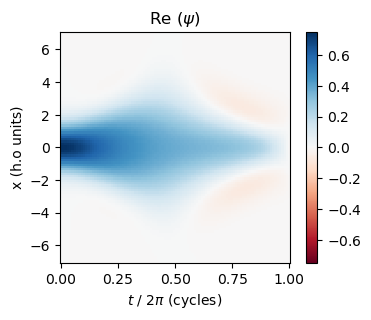

In [28]:
plot_matrix(X_grid, T_grid, psi_normalized.real.detach().numpy(), title = "Re ($\psi$)", folder_name=folder_name, name = 'Re')

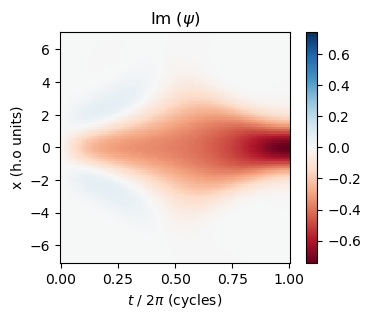

In [29]:
plot_matrix(X_grid, T_grid, psi_normalized.imag.detach().numpy(), title = "Im ($\psi$)", folder_name=folder_name, name = 'Im')

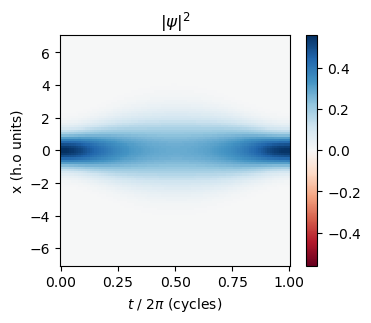

In [30]:
plot_matrix(X_grid, T_grid, psi_sq.detach().numpy(), title = "$|\psi|^2$", folder_name=folder_name, name = 'Abs')

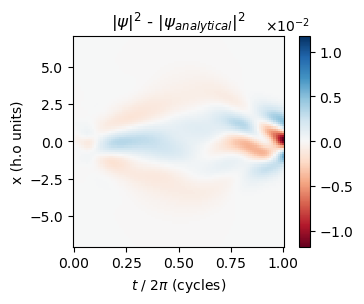

In [31]:
error=psi_sq-torch.abs(psi_analy)**2
plot_matrix(X_grid, T_grid, error.detach().numpy(), title = "$|\psi|^2$ - $|\psi_{analytical}|^2$", folder_name=folder_name, name= 'Error')

## Saving data

### Saving model

This saves the trained model weights to file so that you can load them later without retraining. Execute this cell after training finishes to store the model.

In [36]:
torch.save(net.state_dict(), f"{folder_name}/{folder_name}_net.pth")

print(f"Saved neural network weights to {folder_name}_net.pth")

Saved neural network weights to w_0.5_100000_0.01_40_40_100_2_net.pth


### Saving numerical results

This saves the computed numerical arrays (e.g., observables or wavefunctions) to `.npy` or `.txt` files for later analysis or plotting.

In [37]:
X_np = X_grid.detach().cpu().numpy()
T_np = T_grid.detach().cpu().numpy()
psi_np = psi_grid.detach().cpu().numpy()

np.savez(f"{folder_name}/{folder_name}", X=X_np, T=T_np, psi=psi_np)

In [35]:
# === Prepare values ===
final_total_loss = losswcd_accum[-1]
final_tdse_loss = TDSE_accum[-1]
final_ini_loss = ini_accum[-1]
final_edges_loss = edges_accum[-1]
final_density_error = error.sum().item()
mean_density_error = error.mean().item()

# === Write to file ===
report_path = f"{folder_name}/{folder_name}_report.txt"

with open(report_path, "w") as f:
    f.write(f"Final Report for Run: {folder_name}\n")
    f.write("="*40 + "\n")
    f.write(f"Total Loss        : {final_total_loss:.6e}\n")
    f.write(f"TDSE Loss         : {final_tdse_loss:.6e}\n")
    f.write(f"Initial Cond Loss : {final_ini_loss:.6e}\n")
    f.write(f"Edges Loss        : {final_edges_loss:.6e}\n")
    f.write(f"Density Error     : {error.sum():.6e}\n")
    f.write(f"Mean Density Error: {error.mean():.6e}\n")
    f.write(f"Training Time: {total_time/60:.2f} minutes \n")
    f.write(f"Overlap: {overlap.item():.6e}\n")
    f.write(f"Mean Relative Energy Error: {mean_rel_error:.6e}\n")
    f.write(f"Max Relative Energy Error: {max_rel_error:.6e}\n")